# Using convolutional neural network (CNN) to detect pneumonia from a chest xray

## Final Project Submission

Please fill out:


*   **Student Name:** Cassarra Groesbeck
*   **Student pace:** Part Time/ Flex
*   **Scheduled project review date/time:**
*   **Instructor name:**
*   **Blog post URL:**
---

# 1. Introduction

According to the latest publication from Meticulous Research®, the global X-ray detectors market is expected to register a CAGR of 6% during the forecast period 2022–2029 to reach $4.30 billion by 2029. The growing adoption of digital X-ray detectors, rising demand for X-ray imaging in industrial and security markets, growing geriatric population coupled with rising prevalence of chronic diseases & respiratory infections, and increasing utilization of X-ray detectors for early diagnosis & clinical applications are considered to have a positive impact on the global X-ray detectors market.[TOP 10 COMPANIES IN X-RAY DETECTORS MARKET](https://meticulousblog.org/top-10-companies-in-x-ray-detectors-market/)

[GE Healthcare](https://www.gehealthcare.com/insights/article/achieving-greater-connectivity-in-radiology-through-digitization-and-ai) is a leading provived of digital radiology imagaing equipment and software, as well as leading the way with integration of AI into these systems. 

## 1a. Business Understanding

They currently have on the market Critical Care Suite 2.01 (CCS), a collection of AI algorithms embedded on X-ray systems for automated measurements, case prioritization and quality control. The application automatically analyzes images on a GE X-ray system and highlights critical information on chest X-rays including Endotracheal Tube Positioning, Pneumothorax Triage and Notifications, and Quality Care Suite2 AI algorithms that operate in parallel and help technologists reduce image quality errors and improve efficiency. [GE Healthcare](https://apps.gehealthcare.com/app-products/critical-care-suite-2) 

GE Healthcare is expanding their collection of AI algorithms used when automatically analyzing images. One part of this expanded collection will screen for pneumonia and flag cases of concern.



## 1b. Objectives 
Build a model that can detect pneumonia to be integrate into GE Healthcare's collection of AI algorithms embedded on the Critical Care Suite 2.01 X-ray systems.

---

# 2. Data Understanding

The dataset comes from Kermany et al. on [Mendeley Data](https://data.mendeley.com/datasets/rscbjbr9sj/3). Images are from University of California San Diego, Guangzhou Women and Children's Medical Center and contains frontal chest X-rays of children and women. This is a large dataset with 5856 total radiographs; 1583 NORMAL and 4273 PNEUMONIA, both bacterial pneumonia and viral pneumonia. 

*This notebook is intended for educational purposes only and any resulting model(s) should not be used for any medical purposes.*

---

# 3. Imports

In [1]:
import os, shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy
import numpy as np
import pandas as pd
from PIL import Image
from scipy import ndimage
from tensorflow.keras.preprocessing.image import ImageDataGenerator #, array_to_img, img_to_array, load_img
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

np.random.seed(123)

# 4. Functions

## 4a. View first 20 images in a data set
Similar to the way you may want to preview the head of a dataframe, I will use this function to quickly view the first 20 images of a dataset.

In [2]:
def preview_first_20(images, labels, title):
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(10,10))
    for n in range(20):
        i = n //5
        j = n%5
        ax = axes[i][j]
        ax.imshow(images[n].reshape(256, 256), cmap=plt.cm.gray)
        ax.set_xticks([128])
        if labels[n] == 0:
            ax.set_xticklabels(['Normal'])
        else:
            ax.set_xticklabels(['Pneumonia'])
        ax.set_yticks([])
        if n == 2:
            ax.set_title(title, 
                         fontsize=25, 
                         pad=20);

## 4b. Plot loss and accuracy across epochs

This function will use the dictionary created during .fit method -OR- a pandas df to plot a models loss and accuracy, of both training and validation data, across epochs

In [3]:
def plot_loss_accuracy(results_dict_or_df):
    train_loss = results_dict_or_df['loss']
    train_acc = results_dict_or_df['accuracy']
    val_loss = results_dict_or_df['val_loss']
    val_acc = results_dict_or_df['val_accuracy']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=ax1, label='train_loss')
    sns.lineplot(x=range(len(train_loss)), y=train_acc, ax=ax2, label='train_accuracy')

    sns.lineplot(x=range(len(train_loss)), y=val_loss, ax=ax1, label='val_loss')
    sns.lineplot(x=range(len(train_loss)), y=val_acc, ax=ax2, label='val_accuracy');

## 4c. Confusion Matrix and Classification Report
This function plots confusion matrix and classification report and gives the number and percentage of misclassified images as the plot title. It returns the indices of the misclassified images to use for plotting the misclassified images.

In [4]:
def evaluate_model(images, labels, predictions):
    # three variables to use in confusion matrix
    class_labels = list(train_downsampled_generator.class_indices.keys()) 
    true_classes = list(labels)
    predicted_classes = []
    
    # get predictions from model
    #preds = model.predict(images, batch_size=10)
    
    # populate predicted_classes
    for prediction in predictions:
        if prediction >= .5:
            predicted_classes.append(1.)
        else:
            predicted_classes.append(0.)

    # get index of incorrect predictions
    indices_of_incorrect_predictions = []
    for n in range(len(true_classes)):
        if true_classes[n] != predicted_classes[n]:
            indices_of_incorrect_predictions.append(n)

    # number and percent of incorrect predictions
    n_incorrect_preds = len(indices_of_incorrect_predictions)
    total_cases = len(true_classes)
    percent_wrong = (n_incorrect_preds/total_cases)*100
    
    # save classification report as a dictionary
    report = classification_report(true_classes, 
                                   predicted_classes, 
                                   target_names=class_labels, 
                                   zero_division=0, 
                                   output_dict=True)   
    
    # plot confusion matrix and classification report side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))
    
    fig.suptitle(f'This model mislabeled {n_incorrect_preds} images ({round(percent_wrong, 2)}%)', 
                 color='tab:blue', 
                 size=17)

    ax1.set_title("Confusion Matrix", size=15)
    ax2.set_title("Classification Report", size=15)

    ConfusionMatrixDisplay.from_predictions(true_classes, 
                                            predicted_classes, 
                                            cmap="Blues", 
                                            display_labels=class_labels, 
                                            ax=ax1);

    # code for plotting classification report inspired from:
    # https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
    sns.heatmap(pd.DataFrame(report).iloc[:-1, :].T, 
                annot=True, 
                vmin=.5, 
                vmax=1, 
                cmap="Blues", 
                linewidths=2, 
                ax=ax2);
    
    return indices_of_incorrect_predictions

## 4d. Convert the dictionary from .fit method to a pandas df
To save time when re running this notebook I will save each model after fitting. Converting the resulting results.history dictionary to a df is the easiest way to have access to data for plotting loss and accuracy when bypassing fit method.

In [5]:
def to_df(results_dict):
    return pd.DataFrame(results_dict, columns=results_dict.keys())

## 4e. Combine model.evaluate from training and test data into one df
With each model metrics saved in it's own df I can concatinate the df at tend of notebook to easily assess progression. 


In [6]:
def dot_evaluate_to_df(models_string_name, model, x_train, y_train, x_test, y_test):
    # evaluate on training and test data
    train = model.evaluate(x_train, y_train, verbose=0)
    test = model.evaluate(x_test, y_test, verbose=0)
    # create dfs
    train_df = pd.DataFrame([train], columns=['train_loss', 'train_acc'], index=[models_string_name])
    test_df = pd.DataFrame([test], columns=['test_loss', 'test_acc'], index=[models_string_name])
    # combine dfs
    combo = pd.concat([train_df, test_df], axis=1)
    # add difference between train and test metrics to df
    combo['loss_diff'] = abs(combo['train_loss']-combo['test_loss'])
    combo['acc_diff'] = abs(combo['train_acc']-combo['test_acc'])
    
    return combo

# 5. Exploring the data

## 5a. Load the data

In [7]:
# file paths
test_dir = 'data/CellData/chest_xray/test/'
test_dir_norm = 'data/CellData/chest_xray/test/NORMAL'
test_dir_pneum = 'data/CellData/chest_xray/test/PNEUMONIA'

train_dir = 'data/CellData/chest_xray/train/'
train_dir_norm = 'data/CellData/chest_xray/train/NORMAL'
train_dir_pneum = 'data/CellData/chest_xray/train/PNEUMONIA'

# create objects 
test_norm = [file for file in os.listdir(test_dir_norm) if file.endswith('.jpeg')]
test_pneum = [file for file in os.listdir(test_dir_pneum) if file.endswith('.jpeg')]

train_norm = [file for file in os.listdir(train_dir_norm) if file.endswith('.jpeg')]
train_pneum = [file for file in os.listdir(train_dir_pneum) if file.endswith('.jpeg')]

# check numbers     
print('There are', len(test_norm), 'NORMAL test images')
print('There are', len(test_pneum), 'PNEUMONIA test images')
print()
print('There are', len(train_norm), 'NORMAL train images')
print('There are', len(train_pneum), 'PNEUMONIA train images')
print()

# get data & normalize 
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir, 
                                                                        color_mode="grayscale",
                                                                        class_mode="binary",
                                                                        batch_size=624) 

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(train_dir, 
                                                                         color_mode="grayscale",
                                                                         class_mode="binary",
                                                                         batch_size=5232)

# create the datasets 
test_images, test_labels = next(test_generator)
train_images, train_labels = next(train_generator)

# reshape
test_img = test_images.reshape(test_images.shape[0], -1)
train_img = train_images.reshape(train_images.shape[0], -1)

# sanity check 
print()
print("test_images shape: " + str(test_images.shape)) # before reshaping
print("test_img shape: " + str(test_img.shape))       # after reshaping
print("test_labels shape: " + str(test_labels.shape))
print()
print("train_images shape: " + str(train_images.shape)) # before reshaping
print("train_img shape: " + str(train_img.shape))       # after reshaping
print("train_labels shape: " + str(train_labels.shape))

There are 234 NORMAL test images
There are 390 PNEUMONIA test images

There are 1349 NORMAL train images
There are 3883 PNEUMONIA train images

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.

test_images shape: (624, 256, 256, 1)
test_img shape: (624, 65536)
test_labels shape: (624,)

train_images shape: (5232, 256, 256, 1)
train_img shape: (5232, 65536)
train_labels shape: (5232,)


## 5b. View first 20 radiographs of training data

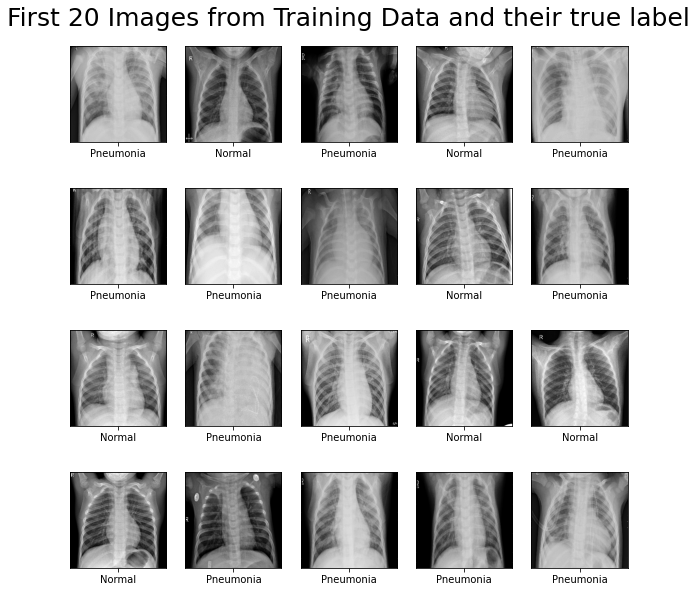

In [8]:
preview_first_20(train_img, train_labels, 'First 20 Images from Training Data and their true label')

# 6. Validation data and Downsampled train set  
## 6a. Create the data
Due to the size of this dataset I will build models with a downsampled set. I want to keep the above training set intact so I can use it at the end of this notebook to train my final model. This means I will need to copy images into new folders. My downsampled train set will consist of 500 images from `train_norm` and 500 from `train_pneum`. I will also create a validation set of images not used in my downsampled train set (25 NORMAL, and 25 PNEUMONIA). 


In [9]:
# new file paths
modeling_data_dir = 'data/CellData/chest_xray/modeling_data'
down_train_dir = os.path.join(modeling_data_dir, 'downsample_train')
down_norm_dir = os.path.join(down_train_dir, 'NORMAL')
down_pneum_dir = os.path.join(down_train_dir, 'PNEUMONIA')
val_dir = os.path.join(modeling_data_dir, 'valdation')
val_norm_dir = os.path.join(val_dir, 'NORMAL')
val_pneum_dir = os.path.join(val_dir, 'PNEUMONIA')

# check if folder already exist
if os.path.exists(modeling_data_dir): # check if folder already exist
    print('Data has already been downsampled and is ready for ImageDataGenerator.') 
    print('\tDownsampled training data directory is: down_train_dir')
    print('\t\tThere are 500 NORMAL images in this downsampled train set')
    print('\t\tThere are 500 PNEUMONIA images in this downsampled train set')
    print('\tValidation data directory is: val_dir')
    print('\t\tThere are 25 NORMAL images in the validation set')
    print('\t\tThere are 25 PNEUMONIA images in the validation set')
    
# if not, create new directories and divide data
else:
    # generate 500 random indices from train data
    downsample_indices_norm = random.sample(range(0, len(train_norm)), 500)
    downsample_indices_pneum = random.sample(range(0, len(train_pneum)), 500)
    # generate 25 random indices from train data that are not in downsampled data
    val_indices_norm = []
    while len(val_indices_norm) < 25:
        index = random.randint(0, len(train_norm))
        if index not in downsample_indices_norm or val_indices_norm:
            val_indices_norm.append(index)
            
    val_indices_pneum = []
    while len(val_indices_pneum) < 25:
        index = random.randint(0, len(train_pneum))
        if index not in downsample_indices_pneum or val_indices_pneum:
            val_indices_pneum.append(index)
    
    # selected images using randomly generated indices
    train_down_norm = [train_norm[i] for i in downsample_indices_norm]
    train_down_pneum = [train_pneum[i] for i in downsample_indices_pneum]
    val_norm = [train_norm[i] for i in val_indices_norm]
    val_pneum = [train_pneum[i] for i in val_indices_pneum]
    
    # create new folders
    print('Creating new folders...')
    os.mkdir(modeling_data_dir)
    os.mkdir(down_train_dir)
    os.mkdir(down_norm_dir)
    os.mkdir(down_pneum_dir)
    os.mkdir(val_dir)
    os.mkdir(val_norm_dir)
    os.mkdir(val_pneum_dir)

    # copy images into new folders
    print('Copying images to new folders...')
    for img in train_down_norm:
        origin = os.path.join(train_dir_norm, img)
        destination = os.path.join(down_norm_dir, img)
        shutil.copyfile(origin, destination)
        
    for img in train_down_pneum:
        origin = os.path.join(train_dir_pneum, img)
        destination = os.path.join(down_pneum_dir, img)
        shutil.copyfile(origin, destination)
        
    for img in val_norm:
        origin = os.path.join(train_dir_norm, img)
        destination = os.path.join(val_norm_dir, img)
        shutil.copyfile(origin, destination)
    
    for img in val_pneum:
        origin = os.path.join(train_dir_pneum, img)
        destination = os.path.join(val_pneum_dir, img)
        shutil.copyfile(origin, destination)
    
    print('Data is now ready for ImageDataGenerator.')
    print('\tDownsampled training data directory is: down_train_dir')
    print('\t\tThere are', len(train_down_norm), 'NORMAL images in this downsampled train set')
    print('\t\tThere are', len(train_down_pneum), 'PNEUMONIA images in this downsampled train set')
    print('\tValidation data directory is: val_dir')
    print('\t\tThere are', len(val_norm), 'NORMAL images in the validation set')
    print('\t\tThere are', len(val_pneum), 'PNEUMONIA images in the validation set')

Data has already been downsampled and is ready for ImageDataGenerator.
	Downsampled training data directory is: down_train_dir
		There are 500 NORMAL images in this downsampled train set
		There are 500 PNEUMONIA images in this downsampled train set
	Validation data directory is: val_dir
		There are 25 NORMAL images in the validation set
		There are 25 PNEUMONIA images in the validation set


In [10]:
# get data, normalize, and reshape
train_downsampled_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(down_train_dir, 
                                                                                     color_mode="grayscale",
                                                                                     class_mode="binary",
                                                                                     batch_size=1000)

val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                       color_mode="grayscale",
                                                                       class_mode="binary",
                                                                       batch_size=50)

# create the data sets
down_images, down_labels = next(train_downsampled_generator)
val_images, val_labels = next(val_generator)

# reshape 
down_img = down_images.reshape(down_images.shape[0], -1)
val_img = val_images.reshape(val_images.shape[0], -1)

# check
print()
print("down_images shape: " + str(down_images.shape)) # before reshaping
print("down_img shape: " + str(down_img.shape))       # after reshaping
print("down_labels shape: " + str(down_labels.shape))
print()
print("val_images shape: " + str(val_images.shape)) # before reshaping
print("val_img shape: " + str(val_img.shape))       # after reshaping
print("val_labels shape: " + str(val_labels.shape))

Found 1000 images belonging to 2 classes.
Found 50 images belonging to 2 classes.

down_images shape: (1000, 256, 256, 1)
down_img shape: (1000, 65536)
down_labels shape: (1000,)

val_images shape: (50, 256, 256, 1)
val_img shape: (50, 65536)
val_labels shape: (50,)


## 6b. Preview 20 images from the downsampled training data

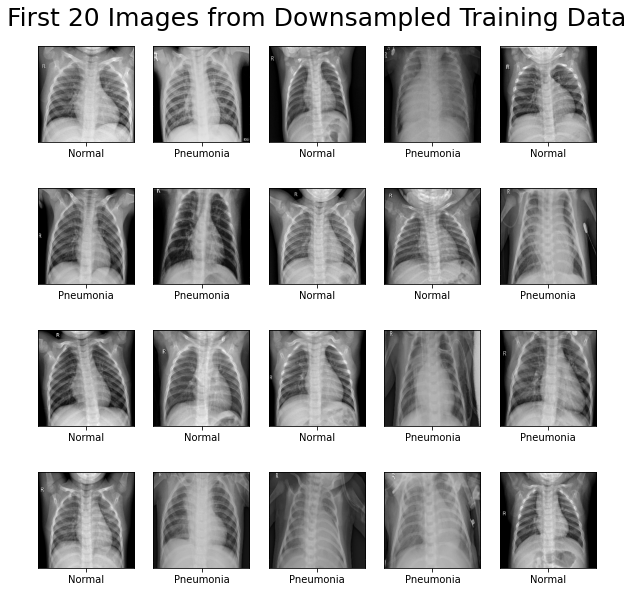

In [11]:
preview_first_20(down_img, down_labels, "First 20 Images from Downsampled Training Data")

# 6.5 Training data - downsample downsampled data
I down sampled to 1000 images but as I started working through notebook it became obvious my laptop and it's cute little cpu is not enuough to process 1000 images in a reasonable amount of time. Fortuitously, images 7 - 507 are an even split of 250 PNEUMONIA and 250 NORMAL. I will keep my downsampled training set intact, incase I want to use it later, and assign new variables x_img, x_images, and y to use as the smaller set or training data.

## 6.5a. Sum labels to count number of 1's (Pneumonia images)

In [12]:
start = 0
stop = 500
while sum(down_labels[start:stop]) != 250.0:
    start+=1
    stop+=1
    
print(f'down_labels[{start}:{stop}] is and even split of 250 PNEUMONIA and 250 NORMAL')

down_labels[7:507] is and even split of 250 PNEUMONIA and 250 NORMAL


## 6.5b. Confirm there are 500 images in this range

In [13]:
len(down_labels[7:507])

500

## 6.5c. Assign x and y variables for reduced training set

In [14]:
x_img = down_img[7:507]
x_images = down_images[7:507]
y = down_labels[7:507]

print(x_img.shape)
print(x_images.shape)
print(y.shape)

(500, 65536)
(500, 256, 256, 1)
(500,)


---
---
# MODEL ARCHITECTURE

**OPTIMIZERS:**

SGD: "...recent studies show that Adam often leads to worse generalization performance than SGD for training deep neural networks on image classification tasks" [Adam vs. SGD: Closing the generalization gap on image classification](https://opt-ml.org/papers/2021/paper53.pdf).


**ACTIVATION FUNCTION:**

For hidden layers: ReLU, This is the standard activation function for hidden layers and I could not find any information that suggested swaying from this norm would be beneficial to this classification task

For output neron: Sigmoid, becuase this is a binary classification we can use sigmoid function to give probability of a given image being pneumonia. These probability predictions range from 0-1 making it easy to convert to percentages if so desired.  

**LOSS:**

binary_crossentropy: This is a binary classification problem

**METRICS:**

accuracy: I am using accuracy because I want a reliable model that does a good job at accurately labeling cases. However, false negatives are a much bigger issue that false positives so in addition to accuracy I will be focusing on pneumonia recall score from the classification report as a secondary metric for guaging model performance. And more specifically, I will be focusing on the difference between training recall scores and testing recall scores, they should be as similar as possible to show that the final model will reliably perform at the same level on new unseen data/cases as it did with the training data. 


---
---

# 7. Create baseline fully connected model
## 7a. Build the layers and view model summary


In [31]:
# Build a baseline fully connected model without convolutional layers
base_model = models.Sequential()

base_model.add(layers.Dense(64, activation='relu', input_dim=x_img.shape[1])) 
base_model.add(layers.Dense(32, activation='relu'))
base_model.add(layers.Dense(10, activation='relu'))
base_model.add(layers.Dense(1, activation='sigmoid'))

base_model.compile(optimizer='SGD',
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

base_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                4194368   
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 10)                330       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 11        
Total params: 4,196,789
Trainable params: 4,196,789
Non-trainable params: 0
_________________________________________________________________


## 7b. Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved base_model model? y/n: n
Epoch 1/50
50/50 [==============================] - 1s 14ms/step - loss: 1.0928 - accuracy: 0.5580 - val_loss: 0.7127 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 1s 16ms/step - loss: 0.6787 - accuracy: 0.6060 - val_loss: 0.7114 - val_accuracy: 0.5000
Epoch 3/50
50/50 [==============================] - 1s 14ms/step - loss: 0.6742 - accuracy: 0.5780 - val_loss: 0.6428 - val_accuracy: 0.6200
Epoch 4/50
50/50 [==============================] - 1s 14ms/step - loss: 0.6055 - accuracy: 0.6860 - val_loss: 0.8908 - val_accuracy: 0.5000
Epoch 5/50
50/50 [==============================] - 1s 15ms/step - loss: 0.4929 - accuracy: 0.7800 - val_loss: 0.4003 - val_accuracy: 0.8600
Epoch 6/50
50/50 [==============================] - 1s 13ms/step - loss: 0.4695 - accuracy: 0.7840 - val_loss: 0.8206 - val_accuracy: 0.5600
Epoch 7/50
50/50 [==============================] - 1s 13ms/step - loss: 0.3875 - ac

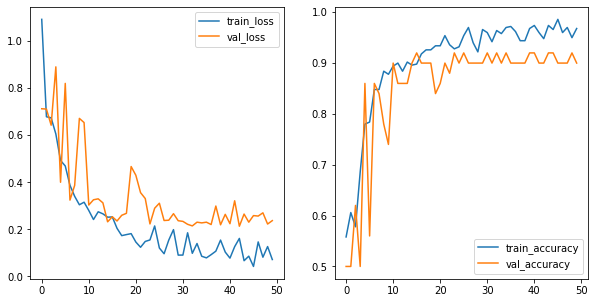

In [32]:
x = input("Would you like to bypass .fit and load saved base_model model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    base_model = models.load_model('base_model.h5')
    # load the df with the loss and accuracy over epochs
    base_model_results_df = pd.read_pickle("./base_model_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(base_model.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(base_model_results_df);

else:
    # fit model
    base_model_results = base_model.fit(x_img,
                                        y,
                                        epochs=50,
                                        batch_size=10,
                                        validation_data=(val_img, val_labels))
    # plot loss and accuracy
    plot_loss_accuracy((base_model_results.history));
    # save the model
    base_model.save('base_model.h5')
    # create df from base_model_results.history
    df = to_df(base_model_results.history)
    # save the dictionary from base_model_results
    pd.to_pickle(df, "./base_model_results_df.pkl")

## 7c. Loss and accuracy - training and test data

In [17]:
base_model_metrics_df = dot_evaluate_to_df('base_model', base_model, x_img, y, test_img, test_labels)
base_model_metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.046468,0.988,0.423493,0.866987,0.377024,0.121013


## 7d. Classification report and confusion matrix - training and test data

### Training

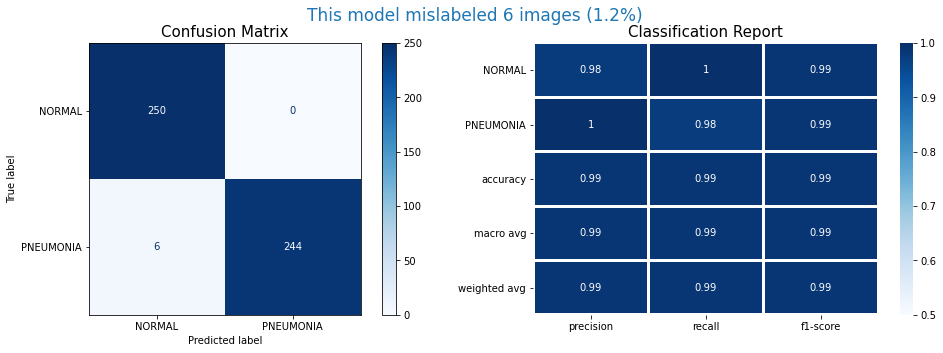

In [18]:
train_preds = base_model.predict(x_img, batch_size=10)

train_indices_of_incorrect_predictions = evaluate_model(x_img, y, train_preds)

### Test

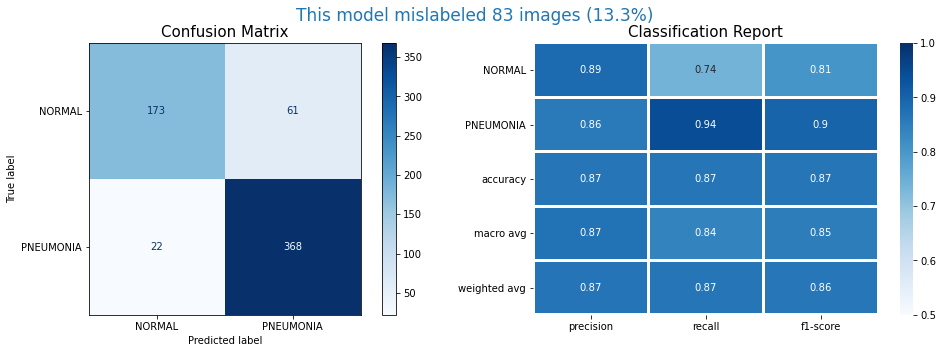

In [19]:
test_preds = base_model.predict(test_img)
indices_of_incorrect_predictions = evaluate_model(test_img, test_labels, test_preds)

## 7e. View misclassified images - training data
Below are the images the model misclassified as well as the models predicted probability of Pnemonia. This is to see if an adjustment in the .5 threshold could help the model capture more true positives. 

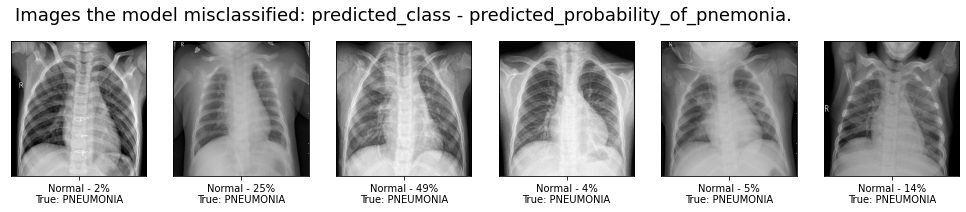

In [20]:
incorrect_images = [x_img[n] for n in train_indices_of_incorrect_predictions]
incorrect_true_labels = [y[n] for n in train_indices_of_incorrect_predictions]
convert_to_percent = [p*100 for p in train_preds]
predicted_proba = [round(list(convert_to_percent[i])[0]) for i in train_indices_of_incorrect_predictions]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,5))
for n in range(len(incorrect_images)):
    #i = n //7
    #j = n%7
    ax = axes[n] #[i][j]
    ax.imshow(incorrect_images[n].reshape(256, 256), cmap=plt.cm.gray)
    ax.set_xticks([128])
    
    # if the true label is 0 (NORMAL) and model was incorrect then model predicted PNEUMONIA
    if incorrect_true_labels[n] == 0: 
        ax.set_xticklabels([f'Pneumonia - {int(predicted_proba[n])}%\nTrue: NORMAL'])
    # conversely, 
    else:
        ax.set_xticklabels([f'Normal - {int(predicted_proba[n])}%\nTrue: PNEUMONIA'])
    
    ax.set_yticks([])
    # tinker with this, either 2,3,4 to get title centered depending on number of columns
    if n == 2:
        ax.set_title("Images the model misclassified: predicted_class - predicted_probability_of_pnemonia.", 
                     fontsize=18, 
                     pad=20);
        

# 8. Create baseline CNN model
## 8a. Add convolutional layers to base model

In [36]:
base_cnn = models.Sequential()
base_cnn.add(layers.Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Conv2D(80, (3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Conv2D(70, (3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
base_cnn.add(layers.MaxPooling2D((2, 2)))

base_cnn.add(layers.Flatten())

base_cnn.add(layers.Dense(64, activation='relu')) 
base_cnn.add(layers.Dense(32, activation='relu'))
base_cnn.add(layers.Dense(10, activation='relu'))
base_cnn.add(layers.Dense(1, activation='sigmoid'))

base_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

base_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 256, 256, 100)     1000      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 100)     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 126, 126, 80)      72080     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 63, 63, 80)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 61, 61, 70)        50470     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 70)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 28, 28, 64)       

## 8b. Define EarlyStopping object

In [37]:
early_stop = EarlyStopping(monitor='val_loss', 
                           min_delta=1e-8,
                           verbose=0,
                           mode='min',
                           patience=10)

## 8c. Fit ,or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved base_cnn model? y/n: n
Epoch 1/50
50/50 [==============================] - 83s 2s/step - loss: 0.6932 - accuracy: 0.5280 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 2/50
50/50 [==============================] - 79s 2s/step - loss: 0.6913 - accuracy: 0.5400 - val_loss: 0.6905 - val_accuracy: 0.7000
Epoch 3/50
50/50 [==============================] - 79s 2s/step - loss: 0.6894 - accuracy: 0.6100 - val_loss: 0.6882 - val_accuracy: 0.5400
Epoch 4/50
50/50 [==============================] - 79s 2s/step - loss: 0.6869 - accuracy: 0.5880 - val_loss: 0.6854 - val_accuracy: 0.6600
Epoch 5/50
50/50 [==============================] - 78s 2s/step - loss: 0.6827 - accuracy: 0.5900 - val_loss: 0.6783 - val_accuracy: 0.7600
Epoch 6/50
50/50 [==============================] - 78s 2s/step - loss: 0.6738 - accuracy: 0.7140 - val_loss: 0.6752 - val_accuracy: 0.5000
Epoch 7/50
50/50 [==============================] - 78s 2s/step - loss: 0.6598 - accuracy: 0

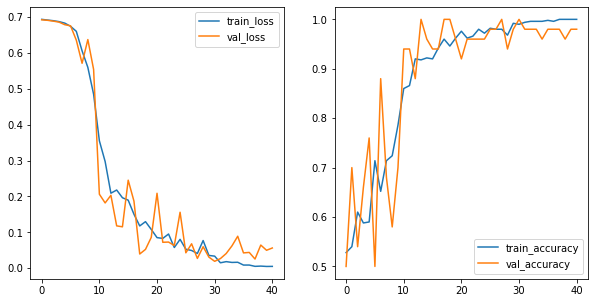

In [38]:
x = input("Would you like to bypass .fit and load saved base_cnn model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    base_cnn = models.load_model('base_cnn.h5')
    # load the df with the loss and accuracy over epochs
    base_cnn_results_df = pd.read_pickle("./base_cnn_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(base_cnn.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(base_cnn_results_df);

else:
    # fit model
    base_cnn_results = base_cnn.fit(x_images,
                                    y,
                                    epochs=50,
                                    batch_size=10,
                                    callbacks=[early_stop],
                                    validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((base_cnn_results.history));
    # save the model
    base_cnn.save('base_cnn.h5')
    # create df from base_cnn_results.history
    df = to_df(base_cnn_results.history)
    # save the dictionary from base_cnn_results
    pd.to_pickle(df, "./base_cnn_results_df.pkl")

## 8d. Loss and accuracy - training and test data
I will join base_model_metrics_df and base_cnn_metrics_df to start a metrics_df

In [39]:
base_cnn_metrics_df = dot_evaluate_to_df('base_cnn', base_cnn, x_images, y, test_images, test_labels)
metrics_df = pd.concat([base_model_metrics_df, base_cnn_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.046468,0.988,0.423493,0.866987,0.377024,0.121013
base_cnn,0.002622,1.000,0.666623,0.892628,0.664000,0.107372


## 8e. Classification report and confusion matrix - training and test data

### Training

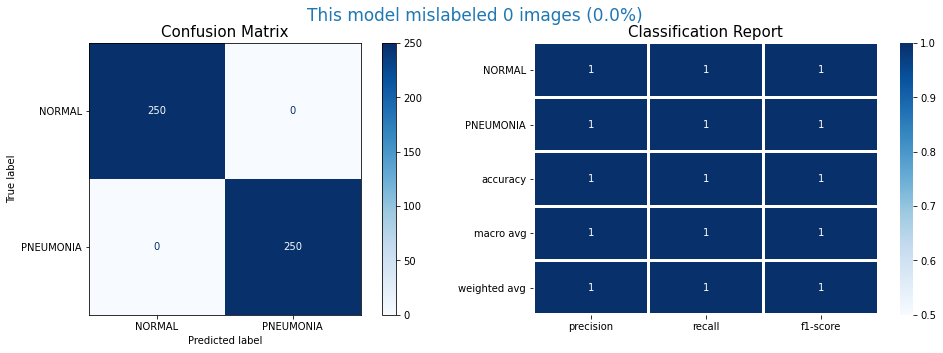

In [40]:
train_preds = base_cnn.predict(x_images, batch_size=10)
cnn_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

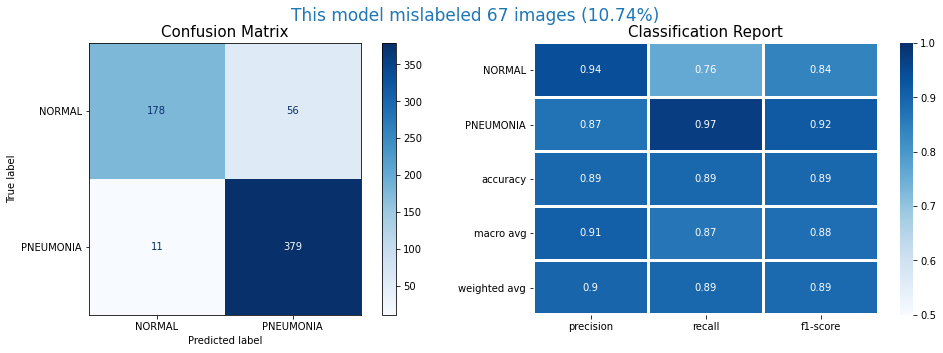

In [42]:
test_preds = base_cnn.predict(test_images)
cnn_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## 8f. Compare two models

In [102]:
convert_base_model = {'base_train': {'pneumonia_recall': .98, 'misclassified': .012, 'accuracy':.99},
                      'base_test': {'pneumonia_recall': .94, 'misclassified': .133, 'accuracy':.87}}

convert_base_cnn  = {'cnn_train': {'pneumonia_recall': 1, 'misclassified': 0, 'accuracy':1},
                      'cnn_test': {'pneumonia_recall': .97, 'misclassified': .107, 'accuracy':.89}}

compare = pd.concat([pd.DataFrame(convert_base_model),pd.DataFrame(convert_base_cnn)], axis=1).T
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.012,0.99
base_test,0.94,0.133,0.87
cnn_train,1.00,0.000,1.00
cnn_test,0.97,0.107,0.89


# 9. Add kernel regularization to base_cnn model
There is still a slight over fitting so I will try applying an l2 regularization with a lambda coefficient of .005
## 9a. Add to each fully connect layer

In [55]:
reg_cnn = models.Sequential()
reg_cnn.add(layers.Conv2D(100, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Conv2D(80, (3, 3), activation='relu'))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Conv2D(70, (3, 3), activation='relu'))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
reg_cnn.add(layers.MaxPooling2D((2, 2)))

reg_cnn.add(layers.Flatten())

reg_cnn.add(layers.Dense(64, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
reg_cnn.add(layers.Dense(32, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reg_cnn.add(layers.Dense(10, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reg_cnn.add(layers.Dense(1, activation='sigmoid'))

reg_cnn.compile(optimizer='SGD',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

reg_cnn.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 256, 256, 100)     1000      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 100)     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 126, 126, 80)      72080     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 80)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 70)        50470     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 30, 30, 70)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 28, 28, 64)       

## 9b. Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved reg_cnn model? y/n: n
Epoch 1/50
50/50 [==============================] - 98s 2s/step - loss: 1.6152 - accuracy: 0.5100 - val_loss: 1.6098 - val_accuracy: 0.7400
Epoch 2/50
50/50 [==============================] - 87s 2s/step - loss: 1.6066 - accuracy: 0.5300 - val_loss: 1.6007 - val_accuracy: 0.6400
Epoch 3/50
50/50 [==============================] - 99s 2s/step - loss: 1.5960 - accuracy: 0.5500 - val_loss: 1.5912 - val_accuracy: 0.5200
Epoch 4/50
50/50 [==============================] - 84s 2s/step - loss: 1.5850 - accuracy: 0.6100 - val_loss: 1.5793 - val_accuracy: 0.5400
Epoch 5/50
50/50 [==============================] - 79s 2s/step - loss: 1.5732 - accuracy: 0.7060 - val_loss: 1.5661 - val_accuracy: 0.7200
Epoch 6/50
50/50 [==============================] - 79s 2s/step - loss: 1.5606 - accuracy: 0.6920 - val_loss: 1.5519 - val_accuracy: 0.8800
Epoch 7/50
50/50 [==============================] - 79s 2s/step - loss: 1.5438 - accuracy: 0.

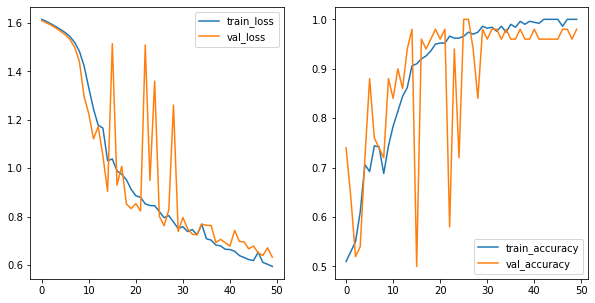

In [56]:
x = input("Would you like to bypass .fit and load saved reg_cnn model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    reg_cnn = models.load_model('reg_cnn.h5')
    # load the df with the loss and accuracy over epochs
    reg_cnn_results_df = pd.read_pickle("./reg_cnn_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(reg_cnn.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(reg_cnn_results_df);

else:
    # fit model
    reg_cnn_results = reg_cnn.fit(x_images,
                                    y,
                                    epochs=50,
                                    batch_size=10,
                                    callbacks=[early_stop],
                                    validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((reg_cnn_results.history));
    # save the model
    reg_cnn.save('reg_cnn.h5')
    # create df from reg_cnn_results.history
    df = to_df(reg_cnn_results.history)
    # save the dictionary from reg_cnn_results
    pd.to_pickle(df, "./reg_cnn_results_df.pkl")

## 9c. Loss and accuracy - training and test data

In [57]:
reg_cnn_metrics_df = dot_evaluate_to_df('reg_cnn', reg_cnn, x_images, y, test_images, test_labels)
metrics_df = pd.concat([metrics_df, reg_cnn_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.046468,0.988,0.423493,0.866987,0.377024,0.121013
base_cnn,0.002622,1.000,0.666623,0.892628,0.664000,0.107372
reg_cnn,0.590643,1.000,1.185085,0.899038,0.594442,0.100962


## 9d. Classification report and confusion matrix - training and test data
### Train

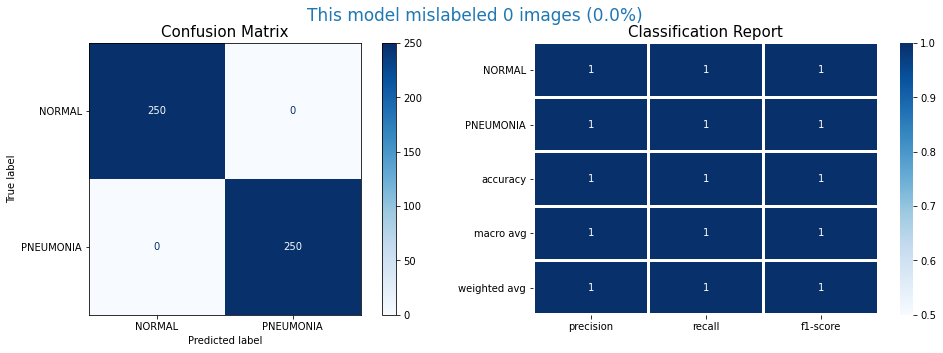

In [58]:
train_preds = reg_cnn.predict(x_images, batch_size=10)
reg_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

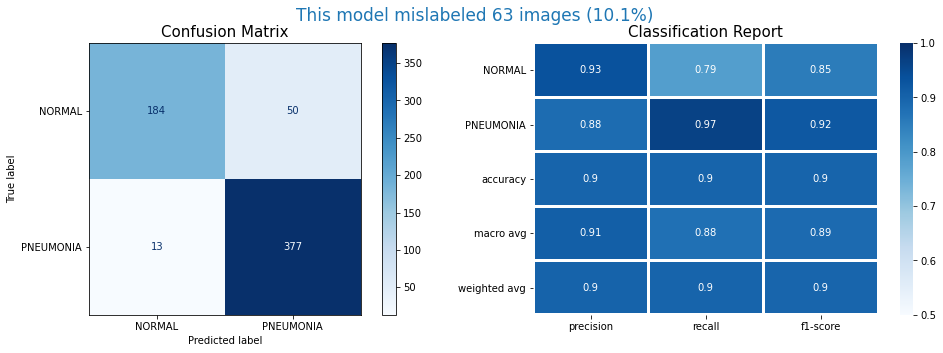

In [60]:
test_preds = reg_cnn.predict(test_images)
reg_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## 9e. Compare the models

In [103]:
convert_reg_cnn  = {'reg_train': {'pneumonia_recall': 1, 'misclassified': 0, 'accuracy':1},
                    'reg_test': {'pneumonia_recall': .97, 'misclassified': .101, 'accuracy':.9}}

add_this = pd.DataFrame(convert_reg_cnn).T


compare = pd.concat([compare, add_this])
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.012,0.99
base_test,0.94,0.133,0.87
cnn_train,1.00,0.000,1.00
cnn_test,0.97,0.107,0.89
reg_train,1.00,0.000,1.00
reg_test,0.97,0.101,0.90


In [95]:
# just the test data
compare.loc[['base_test', 'cnn_test', 'reg_test']]

,pneumonia_recall,misclassified,accuracy
base_test,0.94,0.133,0.87
cnn_test,0.97,0.107,0.89
reg_test,0.97,0.101,0.90


# 10. Reduce nodes
Accuracy between training and validation sets are just a few percentages off but I'd like to see if reducing the number of nodes can close that gap even just a percent or two before I train the model on the entire training set overnight. 
## 10a. Cut number of nodes in half at each layer except output

In [96]:
reduced_nodes = models.Sequential()
reduced_nodes.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Conv2D(40, (3, 3), activation='relu'))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Conv2D(35, (3, 3), activation='relu'))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Conv2D(32, (3, 3), activation='relu'))
reduced_nodes.add(layers.MaxPooling2D((2, 2)))

reduced_nodes.add(layers.Flatten())

reduced_nodes.add(layers.Dense(32, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
reduced_nodes.add(layers.Dense(16, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reduced_nodes.add(layers.Dense(5, kernel_regularizer=regularizers.l2(.005),activation='relu'))
reduced_nodes.add(layers.Dense(1, activation='sigmoid'))

reduced_nodes.compile(optimizer='SGD',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

reduced_nodes.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 256, 256, 50)      500       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 128, 128, 50)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 126, 126, 40)      18040     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 63, 63, 40)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 61, 61, 35)        12635     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 35)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 28, 28, 32)      

## 10b. Fit, or load the model and saved df, plot loss and accuracy over epochs

Would you like to bypass .fit and load saved reduced_nodes model? y/n: n
Epoch 1/50
50/50 [==============================] - 44s 870ms/step - loss: 1.1568 - accuracy: 0.5000 - val_loss: 1.1534 - val_accuracy: 0.6600
Epoch 2/50
50/50 [==============================] - 42s 843ms/step - loss: 1.1513 - accuracy: 0.5580 - val_loss: 1.1479 - val_accuracy: 0.7800
Epoch 3/50
50/50 [==============================] - 45s 901ms/step - loss: 1.1461 - accuracy: 0.5520 - val_loss: 1.1426 - val_accuracy: 0.5000
Epoch 4/50
50/50 [==============================] - 40s 795ms/step - loss: 1.1407 - accuracy: 0.6060 - val_loss: 1.1375 - val_accuracy: 0.5000
Epoch 5/50
50/50 [==============================] - 41s 822ms/step - loss: 1.1353 - accuracy: 0.5980 - val_loss: 1.1319 - val_accuracy: 0.6400
Epoch 6/50
50/50 [==============================] - 39s 788ms/step - loss: 1.1294 - accuracy: 0.6740 - val_loss: 1.1262 - val_accuracy: 0.7000
Epoch 7/50
50/50 [==============================] - 40s 798ms/step - 

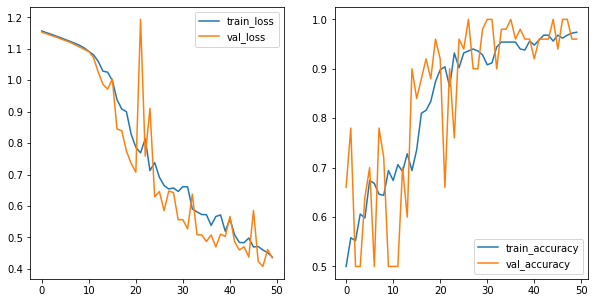

In [97]:
x = input("Would you like to bypass .fit and load saved reduced_nodes model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    reduced_nodes = models.load_model('reduced_nodes.h5')
    # load the df with the loss and accuracy over epochs
    reduced_nodes_results_df = pd.read_pickle("./reduced_nodes_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(reduced_nodes.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(reduced_nodes_results_df);

else:
    # fit model
    reduced_nodes_results = reduced_nodes.fit(x_images,
                                              y,
                                              epochs=50,
                                              batch_size=10,
                                              callbacks=[early_stop],
                                              validation_data=(val_images, val_labels))
    
    # plot loss and accuracy
    plot_loss_accuracy((reduced_nodes_results.history));
    # save the model
    reduced_nodes.save('reduced_nodes.h5')
    # create df from reduced_nodes_results.history
    df = to_df(reduced_nodes_results.history)
    # save the dictionary from reduced_nodes_results
    pd.to_pickle(df, "./reduced_nodes_results_df.pkl")

## 10c. Loss and accuracy - training and test data

In [98]:
reduced_nodes_metrics_df = dot_evaluate_to_df('reduced_nodes', reduced_nodes, x_images, y, test_images, test_labels)
metrics_df = pd.concat([metrics_df, reduced_nodes_metrics_df])
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.046468,0.988,0.423493,0.866987,0.377024,0.121013
base_cnn,0.002622,1.000,0.666623,0.892628,0.664000,0.107372
reg_cnn,0.590643,1.000,1.185085,0.899038,0.594442,0.100962
reduced_nodes,0.427787,0.988,0.660255,0.903846,0.232468,0.084154


## 10d. Classification report and confusion matrix - training and test data
### Train

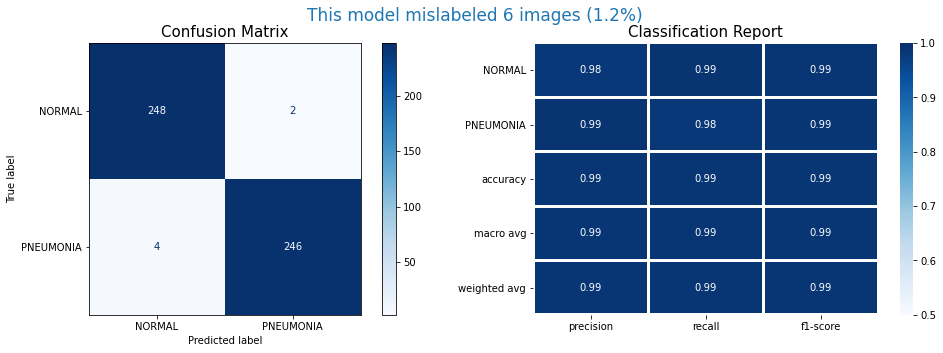

In [99]:
train_preds = reduced_nodes.predict(x_images, batch_size=10)
reduced_train_indices_of_incorrect_predictions = evaluate_model(x_images, y, train_preds)

### Test

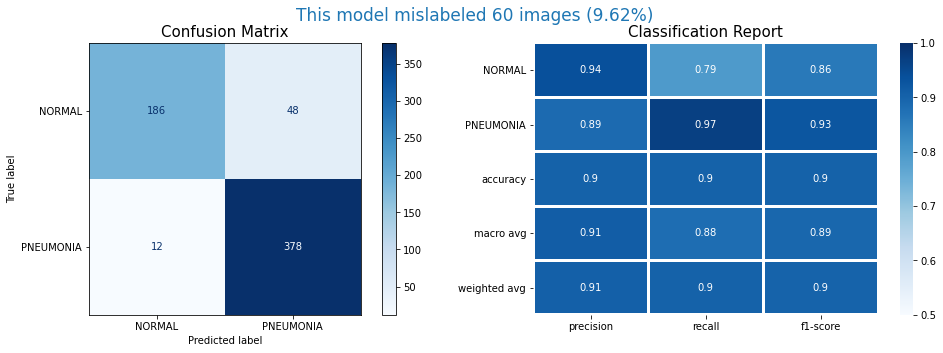

In [100]:
test_preds = reduced_nodes.predict(test_images)
reduced_test_indices_of_incorrect_predictions = evaluate_model(test_images, test_labels, test_preds)

## 10e. View misclassified images - training data
Below are the images the model misclassified as well as the models predicted probability of Pnemonia. This is to see if an adjustment in the .5 threshold could help the model capture more true positives. Luckily, there are only 6 misclassified images, the same as our first model so I can reuse above code from 7e, changing out relivant variables of course.

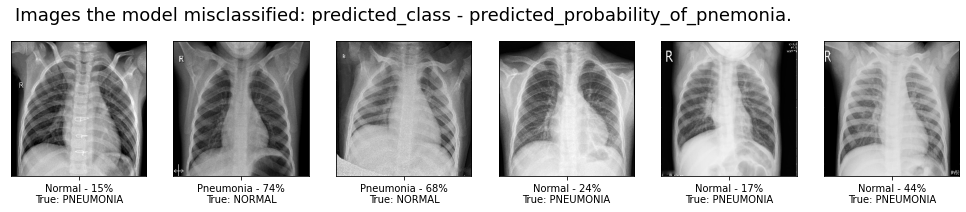

In [113]:
incorrect_images = [x_img[n] for n in reduced_train_indices_of_incorrect_predictions]
incorrect_true_labels = [y[n] for n in reduced_train_indices_of_incorrect_predictions]
convert_to_percent = [p*100 for p in train_preds]
predicted_proba = [round(list(convert_to_percent[i])[0]) for i in reduced_train_indices_of_incorrect_predictions]

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(17,5))
for n in range(len(incorrect_images)):
    #i = n //7
    #j = n%7
    ax = axes[n] #[i][j]
    ax.imshow(incorrect_images[n].reshape(256, 256), cmap=plt.cm.gray)
    ax.set_xticks([128])
    
    # if the true label is 0 (NORMAL) and model was incorrect then model predicted PNEUMONIA
    if incorrect_true_labels[n] == 0: 
        ax.set_xticklabels([f'Pneumonia - {int(predicted_proba[n])}%\nTrue: NORMAL'])
    # conversely, 
    else:
        ax.set_xticklabels([f'Normal - {int(predicted_proba[n])}%\nTrue: PNEUMONIA'])
    
    ax.set_yticks([])
    # tinker with this, either 2,3,4 to get title centered depending on number of columns
    if n == 2:
        ax.set_title("Images the model misclassified: predicted_class - predicted_probability_of_pnemonia.", 
                     fontsize=18, 
                     pad=20);
        

## 10f. Compare the models

In [104]:
convert_reduced  = {'reg_train': {'pneumonia_recall': .98, 'misclassified': .012, 'accuracy':.99},
                    'reg_test': {'pneumonia_recall': .97, 'misclassified': .096, 'accuracy':.9}}

add_this = pd.DataFrame(convert_reduced).T


compare = pd.concat([compare, add_this])
compare

,pneumonia_recall,misclassified,accuracy
base_train,0.98,0.012,0.99
base_test,0.94,0.133,0.87
cnn_train,1.00,0.000,1.00
cnn_test,0.97,0.107,0.89
reg_train,1.00,0.000,1.00
reg_test,0.97,0.101,0.90
reg_train,0.98,0.012,0.99
reg_test,0.97,0.096,0.90


And a reminded of the metrics_df

In [105]:
metrics_df

,train_loss,train_acc,test_loss,test_acc,loss_diff,acc_diff
base_model,0.046468,0.988,0.423493,0.866987,0.377024,0.121013
base_cnn,0.002622,1.000,0.666623,0.892628,0.664000,0.107372
reg_cnn,0.590643,1.000,1.185085,0.899038,0.594442,0.100962
reduced_nodes,0.427787,0.988,0.660255,0.903846,0.232468,0.084154


In this `metrics_df` notice `loss_diff` and `acc_diff` (the difference between loss and accuracy between train and test data) are lowest with this `reduced_nodes` model. 

In the `compare` df notice there is only a 1% difference in Pneumonia recall score. Recall is an important metric because I am trying to capture as many true positives as possible, false negatives could delay important treatment in this vulnerable population.

# 11. FINAL MODEL TRAINING
For the above mentioned reasons I have chosen my final model to be the `reduced_nodes` model. An additional benefit to this model is that it also trains much quicker that the larger node models. 

## 11a. Define the final models architecture 

In [ ]:
final_model = models.Sequential()
final_model.add(layers.Conv2D(50, (3, 3), padding='same', activation='relu', input_shape=(256, 256, 1)))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(40, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(35, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
final_model.add(layers.MaxPooling2D((2, 2)))

final_model.add(layers.Flatten())

final_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(.005), activation='relu')) 
final_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(.005),activation='relu'))
final_model.add(layers.Dense(5, kernel_regularizer=regularizers.l2(.005),activation='relu'))
final_model.add(layers.Dense(1, activation='sigmoid'))

final_model.compile(optimizer='SGD',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

final_model.summary()

## 11b. Fit, or load the model and saved df, plot loss and accuracy over epochs

In [ ]:
x = input("Would you like to bypass .fit and load saved final_model model? y/n: ")
all_y = ['y', 'yes']
if x.lower() in all_y:
    # load the saved model
    final_model = models.load_model('final_model.h5')
    # load the df with the loss and accuracy over epochs
    final_model_results_df = pd.read_pickle("./final_model_results_df.pkl") 
    # print the model summary, to for visual comparision to above
    print(final_model.summary())
    # plot the model loss and accuracy
    plot_loss_accuracy(final_model_results_df);

else:
    # fit model
    final_model_results = final_model.fit(train_images,
                                          train_labels,
                                          epochs=50,
                                          batch_size=10,
                                          callbacks=[early_stop],
                                          validation_data=)
    
    # plot loss and accuracy
    plot_loss_accuracy((final_model_results.history));
    # save the model
    final_model.save('final_model.h5')
    # create df from final_model_results.history
    df = to_df(final_model_results.history)
    # save the dictionary from final_model_results
    pd.to_pickle(df, "./final_model_results_df.pkl")

## 11c.  Loss and accuracy - full training set and test data

In [ ]:
final_model_metrics_df = dot_evaluate_to_df('final_model', final_model, x_images, y, test_images, test_labels)
metrics_df = pd.concat([metrics_df, final_model_metrics_df])
metrics_df

In [124]:
zero = sum(train_labels)/len(train_labels)
one = 1-(zero)
class_weight_dict = {0:zero, 1:one}
class_weight_dict

{0: 0.7421636085626911, 1: 0.25783639143730885}

0.25783639143730885